generation_type
combustible fuels                        0.0
hydraulic turbine                        0.0
nuclear steam turbine                    0.0
other types of electricity generation    0.0
solar                                    0.0
wind power turbine                       0.0
dtype: float64
Epoch 1/50
4/4 - 7s - loss: 83.5815 - mae: 6.4631 - val_loss: 4.8707 - val_mae: 1.8732 - 7s/epoch - 2s/step
Epoch 2/50
4/4 - 0s - loss: 11.3068 - mae: 2.6371 - val_loss: 4.9970 - val_mae: 2.0005 - 395ms/epoch - 99ms/step
Epoch 3/50
4/4 - 0s - loss: 7.3569 - mae: 2.1078 - val_loss: 2.0451 - val_mae: 1.2873 - 392ms/epoch - 98ms/step
Epoch 4/50
4/4 - 0s - loss: 4.1288 - mae: 1.5912 - val_loss: 0.7045 - val_mae: 0.7068 - 355ms/epoch - 89ms/step
Epoch 5/50
4/4 - 0s - loss: 2.3756 - mae: 1.2084 - val_loss: 0.2982 - val_mae: 0.4561 - 296ms/epoch - 74ms/step
Epoch 6/50
4/4 - 0s - loss: 1.6817 - mae: 1.0401 - val_loss: 0.1809 - val_mae: 0.3614 - 297ms/epoch - 74ms/step
Epoch 7/50
4/4 - 0s - loss: 1.

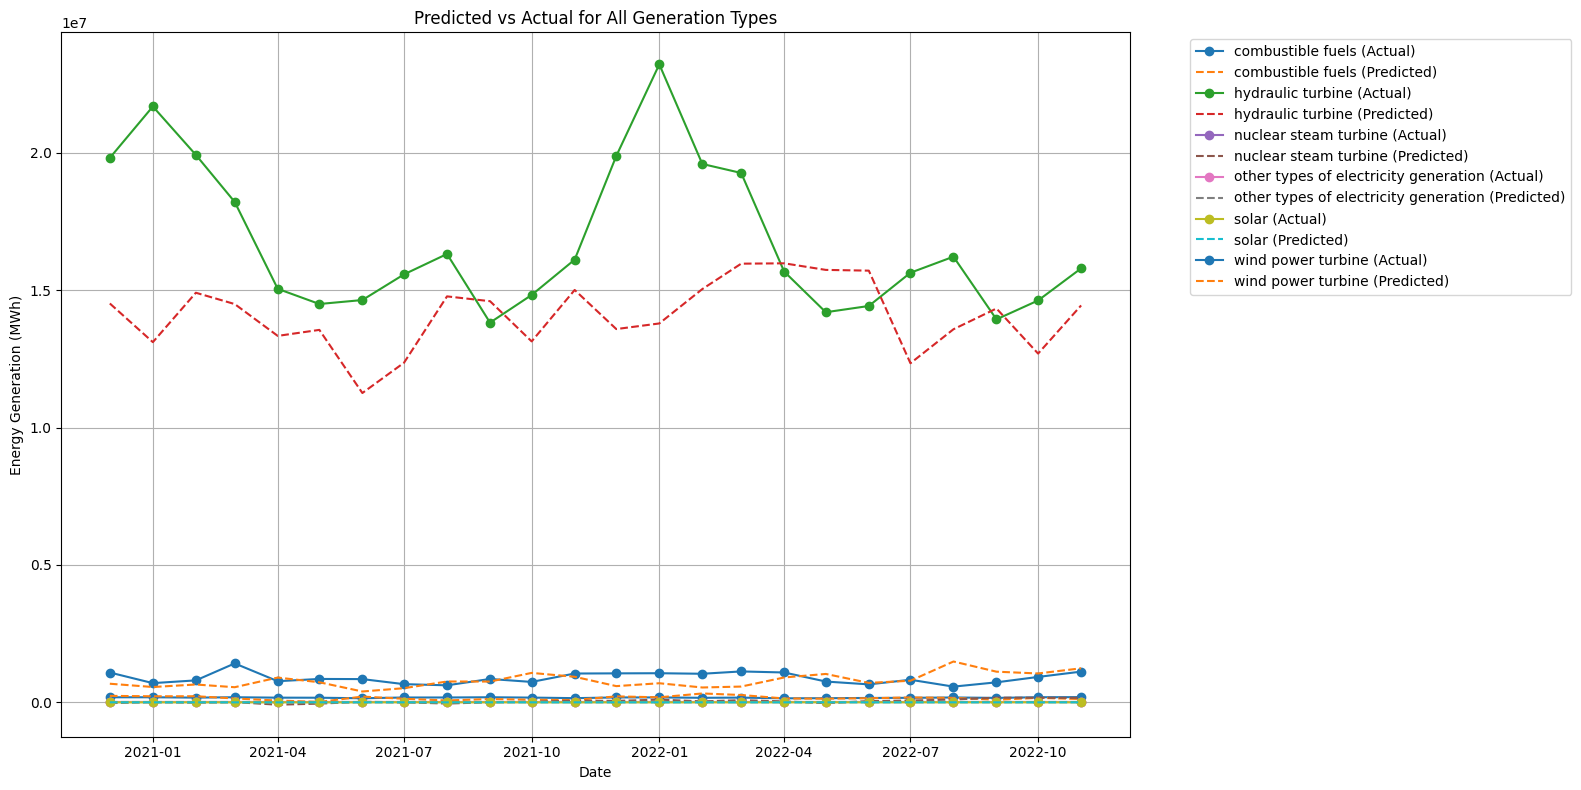

Epoch 1/50
5/5 - 0s - loss: 0.2010 - mae: 0.3504 - 394ms/epoch - 79ms/step
Epoch 2/50
5/5 - 0s - loss: 0.1918 - mae: 0.3375 - 320ms/epoch - 64ms/step
Epoch 3/50
5/5 - 0s - loss: 0.1950 - mae: 0.3482 - 335ms/epoch - 67ms/step
Epoch 4/50
5/5 - 0s - loss: 0.1829 - mae: 0.3355 - 339ms/epoch - 68ms/step
Epoch 5/50
5/5 - 0s - loss: 0.1923 - mae: 0.3461 - 330ms/epoch - 66ms/step
Epoch 6/50
5/5 - 0s - loss: 0.1853 - mae: 0.3376 - 332ms/epoch - 66ms/step
Epoch 7/50
5/5 - 0s - loss: 0.1817 - mae: 0.3347 - 334ms/epoch - 67ms/step
Epoch 8/50
5/5 - 0s - loss: 0.1628 - mae: 0.3165 - 332ms/epoch - 66ms/step
Epoch 9/50
5/5 - 0s - loss: 0.1870 - mae: 0.3389 - 333ms/epoch - 67ms/step
Epoch 10/50
5/5 - 0s - loss: 0.1725 - mae: 0.3223 - 332ms/epoch - 66ms/step
Epoch 11/50
5/5 - 0s - loss: 0.1579 - mae: 0.3119 - 330ms/epoch - 66ms/step
Epoch 12/50
5/5 - 0s - loss: 0.1674 - mae: 0.3192 - 329ms/epoch - 66ms/step
Epoch 13/50
5/5 - 0s - loss: 0.1449 - mae: 0.2981 - 334ms/epoch - 67ms/step
Epoch 14/50
5/5 - 0s 

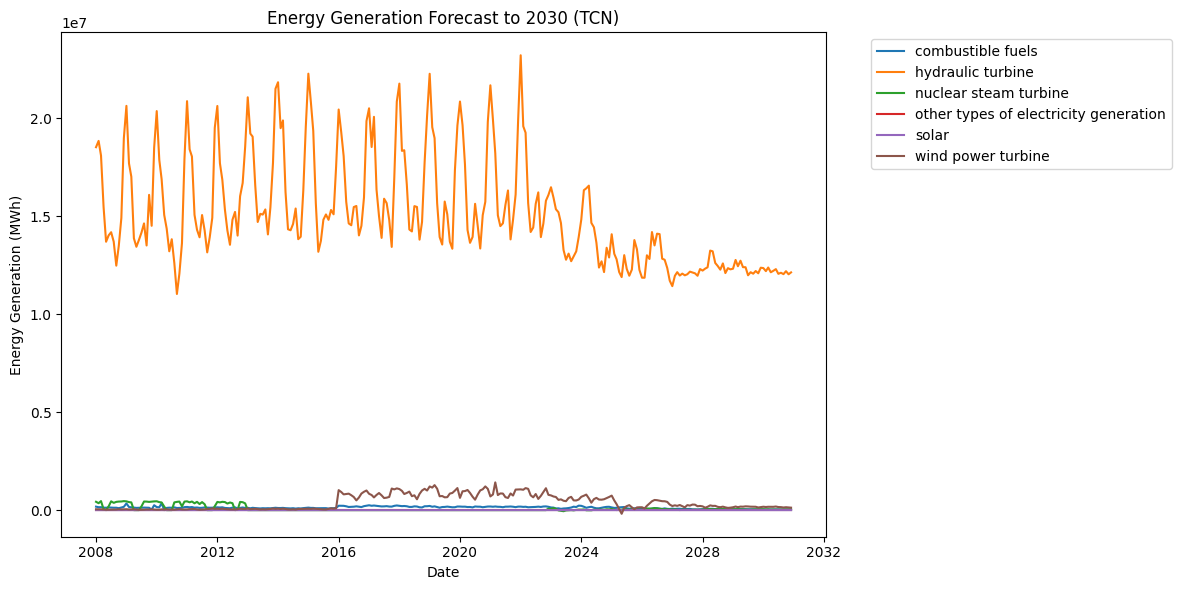

In [85]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tcn import TCN

# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
    return df_grouped

# Ensure all generation types are represented for every date
def standardize_generation_types(df, unique_types):
    all_dates = df['date'].unique()
    standardized_rows = [
        {'date': date, 'generation_type': g_type, 'megawatt_hours': 0}
        for date in all_dates
        for g_type in unique_types
        if g_type not in df[df['date'] == date]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

# Scale the data
def scale_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

# Create input-output sequences for time-series data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Build the TCN model
def build_tcn(input_shape, output_shape):
    model = Sequential([
        Input(shape=input_shape),
        TCN(
            nb_filters=64,
            kernel_size=3,
            nb_stacks=1,
            dilations=(1, 2, 4, 8, 16, 20, 32, 64),
            padding='causal',
            use_skip_connections=True,
            dropout_rate=0.25,
            return_sequences=False,
            activation='relu',
            kernel_initializer='he_normal',
            use_batch_norm=False,
            use_layer_norm=False,
            use_weight_norm=False
        ),
        Dense(output_shape)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Plot forecasted values
def plot_forecasts(df_pivot, forecast_df, title):
    combined = pd.concat([df_pivot, forecast_df])
    plt.figure(figsize=(12, 6))
    for column in df_pivot.columns:
        plt.plot(combined.index, combined[column], label=column)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Energy Generation (MWh)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Forecast future energy generation
def forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, columns):
    forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, data_scaled.shape[1])
    forecast = []
    for _ in range(len(forecast_horizon)):
        prediction = model.predict(forecast_input)
        forecast.append(prediction[0])
        forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    forecast_rescaled = scaler.inverse_transform(forecast)
    return pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=columns)

# Main Script
filepath = r'data\processed\quebec_energy.csv'

# Load and process data
df_grouped = load_and_preprocess_data(filepath)
unique_generation_types = df_grouped['generation_type'].unique()
df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)

df_pivot[df_pivot < 0] = 0
#Check for negative values sum
print(df_pivot[df_pivot < 0].sum())


# Scale the pivoted data
data_scaled, scaler = scale_data(df_pivot)

# Define the number of time steps (look-back period)
n_steps = 36

# Create sequences for training and testing
X, y = create_sequences(data_scaled, n_steps)
test_size = 24  # Assuming monthly data, 24 months = 2 years
train_data, test_data = data_scaled[:-test_size], data_scaled[-test_size - n_steps:]
X_train, y_train = create_sequences(train_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

# Define input and output shapes
input_shape = (n_steps, X_train.shape[2])
output_shape = y_train.shape[1]

# Build and compile the TCN model
tcn_model = build_tcn(input_shape, output_shape)

# Train the model
history = tcn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)

# Predict on the test set
y_pred_test = tcn_model.predict(X_test)

# Rescale predictions and actual values back to their original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)

# Align the lengths for comparison
test_dates = df_pivot.index[-test_size:]
min_length = min(len(test_dates), len(y_test_rescaled), len(y_pred_test_rescaled))
test_dates = test_dates[:min_length]
y_test_rescaled = y_test_rescaled[:min_length]
y_pred_test_rescaled = y_pred_test_rescaled[:min_length]

# Convert to DataFrame for easier handling
comparison_df = pd.DataFrame(data=y_test_rescaled, index=test_dates, columns=df_pivot.columns).rename_axis("Date")
predicted_df = pd.DataFrame(data=y_pred_test_rescaled, index=test_dates, columns=df_pivot.columns).rename_axis("Date")

# Combine actual and predicted values into a single DataFrame for plotting
combined_df = pd.concat([comparison_df.add_suffix(' (Actual)'), predicted_df.add_suffix(' (Predicted')], axis=1)

# Plot all generation types on the same figure
plt.figure(figsize=(16, 8))
for generation_type in df_pivot.columns:
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Actual)'], label=f'{generation_type} (Actual)', marker='o')
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Predicted'], label=f'{generation_type} (Predicted)', linestyle='--')

plt.title("Predicted vs Actual for All Generation Types")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

# Retrain the model on the entire dataset
X_full, y_full = create_sequences(data_scaled, n_steps)
tcn_model.fit(X_full, y_full, epochs=50, batch_size=32, verbose=2)

# Forecast future values
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')
forecast_df_tcn = forecast_future(tcn_model, data_scaled, scaler, n_steps, forecast_horizon, df_pivot.columns)

# Plot the forecast
plot_forecasts(df_pivot, forecast_df_tcn, "Energy Generation Forecast to 2030 (TCN)")
